In [16]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt

In [17]:
print(tf.__version__)

2.13.0


In [18]:
!nvidia-smi

Tue Oct  3 09:41:04 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    32W /  70W |   2213MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#Dataset

In [19]:
!mkdir /content/data

mkdir: cannot create directory ‘/content/data’: File exists


In [20]:
!wget -O /content/data/beatles01.jpg https://raw.githubusercontent.com/chulminkw/DLCV/master/data/image/beatles01.jpg

--2023-10-03 09:41:04--  https://raw.githubusercontent.com/chulminkw/DLCV/master/data/image/beatles01.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 383118 (374K) [image/jpeg]
Saving to: ‘/content/data/beatles01.jpg’

/content/data/beatl 100%[===================>] 374.14K  --.-KB/s    in 0.005s  

2023-10-03 09:41:04 (66.8 MB/s) - ‘/content/data/beatles01.jpg’ saved [383118/383118]



#TFHub에서 SSD Inference 모델 다운로드 후 Inference

- 원하는 모델명은 TF Hub에서 검색해서 hub.lod()로 다운로드.
- 로딩된 모델은 바로 원본 이미지로 Object Detection 가능함. 입력 이미지 값으로 numpy array, tensor 모두 가능하며, uint8로 구성해야함.
- Inference 결과는 dictionary 형태로 반환되며, 개별 key 값은 object detection 모델에 따라 달라질 수 있음. 개별 Value는 tensor로 되어 있음.
- Inference 반환된 bbox 좌표는 이미지 사이즈 대비 스케일링 된 0~1 사이 값이며, ymin, xmin, ymax, xmax 형태로 반환됨.

In [21]:
module_handle = 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2'
detector_model = hub.load(module_handle)

In [22]:
import cv2
import numpy as np
import time

#3-D numpy array를 4-D numpy array로 변경 (number of images)
img_array_np = cv2.imread('/content/data/beatles01.jpg')
img_array = img_array_np[np.newaxis, ...] #새로운 축을 추가해서 4차원으로 만들어줌.
print(img_array_np.shape, img_array.shape)

start_time = time.time()
#image를 detector model에 인자로 입력하여 inference 수행
result = detector_model(img_array)
print('elapsed time:', time.time()-start_time)

(633, 806, 3) (1, 633, 806, 3)
elapsed time: 7.089296579360962


In [23]:
#4-D tensor으로 이미지를 입력
img_tensor = tf.convert_to_tensor(img_array_np, dtype=tf.uint8)[np.newaxis, ...]
start_time = time.time()

#Inference
result = detector_model(img_tensor)
print('elapsed time:', time.time()-start_time)

elapsed time: 0.15692949295043945


In [24]:
print(result)

{'raw_detection_boxes': <tf.Tensor: shape=(1, 1917, 4), dtype=float32, numpy=
array([[[ 0.00631277,  0.00904142,  0.03609154,  0.0340144 ],
        [-0.00856349, -0.07280225,  0.06101338,  0.171888  ],
        [-0.06701753, -0.02872825,  0.1551125 ,  0.09277536],
        ...,
        [ 0.23607221, -0.05441424,  0.82106245,  1.0508178 ],
        [-0.0429309 ,  0.19815403,  1.0614538 ,  0.8055975 ],
        [ 0.23631355,  0.02928007,  0.9821291 ,  0.9564255 ]]],
      dtype=float32)>, 'detection_anchor_indices': <tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[1475.,  435., 1453.,  432.,  369., 1465.,  372.,  420.,  366.,
         470.,  429.,  441.,  477., 1487.,  447.,  444.,  438.,  375.,
         477.,  501.,  450.,  435.,  617.,  477.,  593.,  423.,  363.,
         378.,  605.,  578.,  441.,  366.,  453.,  489.,  438.,  462.,
        1457.,  477.,  363.,  420., 1015., 1575.,  420., 1569.,  465.,
         489.,  495., 1555., 1472., 1569.,  495., 1543.,  474.,  477.,
        

In [26]:
print(result.keys())
print(result['detection_boxes'].shape, result['detection_classes'].shape, result['num_detections'].shape, result['detection_scores'].shape)

dict_keys(['raw_detection_boxes', 'detection_anchor_indices', 'detection_multiclass_scores', 'detection_scores', 'detection_boxes', 'raw_detection_scores', 'num_detections', 'detection_classes'])
(1, 100, 4) (1, 100) (1,) (1, 100)


In [27]:
#bounding box 좌표는 ymin, xmin, ymax, xmax 순서로 반환됨. x가 나중에 오는거 꼭 알아야함!
#좌표 값은 원본 이미지의 width, height으로 0-1 사이의 값으로 정교화됨.
print(result['detection_boxes'])

tf.Tensor(
[[[0.41495603 0.478908   0.8861092  0.6805987 ]
  [0.3544619  0.6193309  0.4560114  0.71033895]
  [0.42462417 0.07202519 0.87260556 0.24962679]
  [0.3484032  0.57042295 0.42650554 0.6450171 ]
  [0.35190704 0.49550366 0.3720645  0.51862085]
  [0.43273574 0.28204626 0.8654354  0.45395404]
  [0.34878343 0.54638815 0.3778478  0.57632303]
  [0.37359872 0.38559076 0.41415027 0.42749038]
  [0.3549313  0.4574385  0.3715493  0.47196677]
  [0.38732833 0.16212596 0.5466345  0.31490028]
  [0.35574898 0.53846574 0.41043958 0.5955771 ]
  [0.35995907 0.7496102  0.45185715 0.80073214]
  [0.4196226  0.37767804 0.49098235 0.4162867 ]
  [0.40850347 0.6971656  0.8881627  0.875424  ]
  [0.37630153 0.8410377  0.41588664 0.88230294]
  [0.38690457 0.8088865  0.42234334 0.8531972 ]
  [0.3554615  0.6691954  0.45342818 0.7328212 ]
  [0.33963874 0.5889446  0.3827575  0.64008933]
  [0.4196226  0.37767804 0.49098235 0.4162867 ]
  [0.3990191  0.79988337 0.5149194  0.8531636 ]
  [0.37458175 0.89691687 0.42

##Inference 결과를 이미지로 시각화

In [28]:
#result 내의 value들을 모두 numpy로 변환. visualization하기에는 tensor보다 numpy가 더 쉬움.
result = {key:value.numpy() for key, value in result.items()}


In [29]:
# 1부터 91까지의 COCO Class id 매핑.
labels_to_names = {1:'person',2:'bicycle',3:'car',4:'motorcycle',5:'airplane',6:'bus',7:'train',8:'truck',9:'boat',10:'traffic light',
                    11:'fire hydrant',12:'street sign',13:'stop sign',14:'parking meter',15:'bench',16:'bird',17:'cat',18:'dog',19:'horse',20:'sheep',
                    21:'cow',22:'elephant',23:'bear',24:'zebra',25:'giraffe',26:'hat',27:'backpack',28:'umbrella',29:'shoe',30:'eye glasses',
                    31:'handbag',32:'tie',33:'suitcase',34:'frisbee',35:'skis',36:'snowboard',37:'sports ball',38:'kite',39:'baseball bat',40:'baseball glove',
                    41:'skateboard',42:'surfboard',43:'tennis racket',44:'bottle',45:'plate',46:'wine glass',47:'cup',48:'fork',49:'knife',50:'spoon',
                    51:'bowl',52:'banana',53:'apple',54:'sandwich',55:'orange',56:'broccoli',57:'carrot',58:'hot dog',59:'pizza',60:'donut',
                    61:'cake',62:'chair',63:'couch',64:'potted plant',65:'bed',66:'mirror',67:'dining table',68:'window',69:'desk',70:'toilet',
                    71:'door',72:'tv',73:'laptop',74:'mouse',75:'remote',76:'keyboard',77:'cell phone',78:'microwave',79:'oven',80:'toaster',
                    81:'sink',82:'refrigerator',83:'blender',84:'book',85:'clock',86:'vase',87:'scissors',88:'teddy bear',89:'hair drier',90:'toothbrush',
                    91:'hair brush'}

In [30]:
def get_ssd_detector(module="https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2"):
  detector = hub.load(module_handle)
  return detector

detector_model = get_ssd_detector()

person: 0.7767
person: 0.7362
car: 0.7209
person: 0.7084
car: 0.6868
person: 0.6846
car: 0.6652
car: 0.6145
car: 0.5854
car: 0.5724
car: 0.5606
car: 0.5341
person: 0.5228


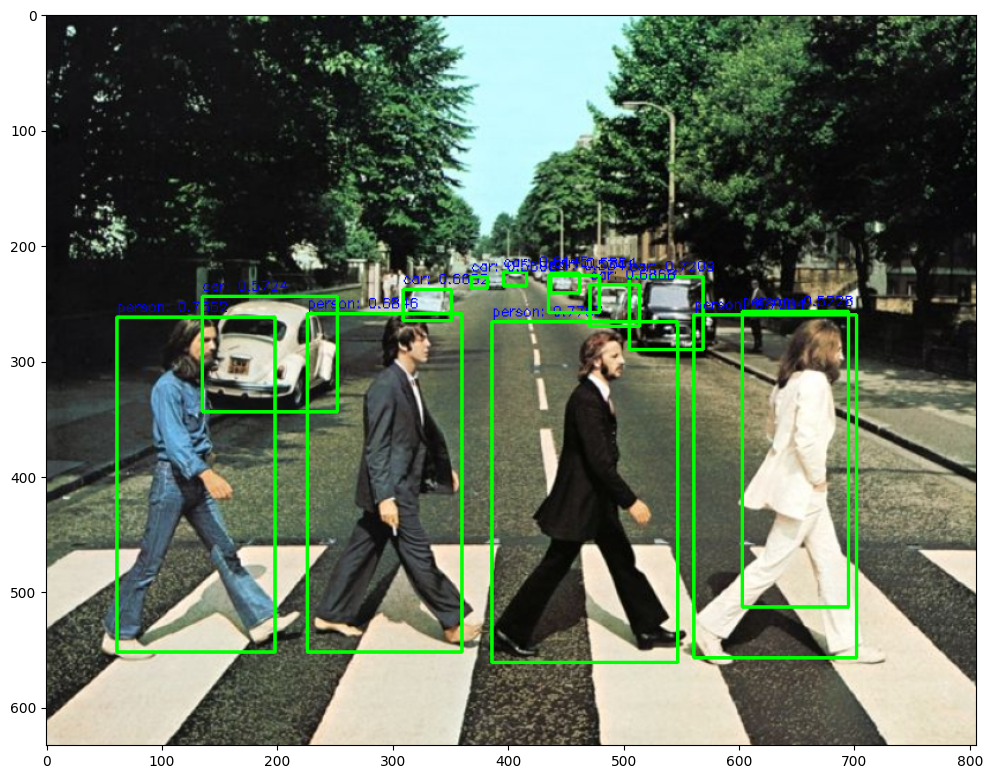

In [31]:
import cv2

img_array = cv2.cvtColor(cv2.imread('/content/data/beatles01.jpg'), cv2.COLOR_BGR2RGB)

#scaling된 이미지를 기반으로 bounding box의 위치가 예측되므로 이를 다시 복원하기 위해서는 원본 이미지의 shape 정보가 필요하다
height = img_array.shape[0]
width = img_array.shape[1]

draw_img = img_array.copy()

#bounding box color and letter color
green_color = (0, 255, 0)
red_color = (0, 0, 255)

#cv2로 만들어진 numpy image array를 tensor으로 변환
img_tensor = tf.convert_to_tensor(img_array, dtype=tf.uint8)[tf.newaxis, ...]

#ssd+mobilenetv2 모델을 다운로드 하고 inference
result = detector_model(img_tensor)
result = {key:value.numpy() for key, value in result.items()}

SCORE_THRESHOLD = 0.5
OBJECT_DEFAULT_COUNT = 100

#detect된 object들을 iteration하며 정보를 추출한다. detect된 object의 수는 100.
for i in range(min(result['detection_scores'][0].shape[0], OBJECT_DEFAULT_COUNT)):
  #detection score을 iteration마다 높은 순으로 추출, score_threshold보다 낮으면 loop 중단
  score = result['detection_scores'][0, i]
  if score < SCORE_THRESHOLD:
    break
  #deteced된 object들은 scale된 기준으로 예측됨. 그래서 다시 원본 이미지 비율로 걔산.
  box = result['detection_boxes'][0, i]

  left = box[1] * width
  top = box[0] * height
  right = box[3] * width
  bottom = box[2] * height

  class_id = result['detection_classes'][0, i]
  caption = "{}: {:.4f}".format(labels_to_names[class_id], score)
  print(caption)

  cv2.rectangle(draw_img, (int(left), int(top)), (int(right), int(bottom)), color = green_color, thickness = 2)
  cv2.putText(draw_img, caption, (int(left), int(top - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, red_color, 1)

plt.figure(figsize=(12, 12))
plt.imshow(draw_img)

In [32]:
import time

def get_detected_img(model, img_array, score_threshold, object_show_count=100, is_print=True):
  # scaling된 이미지 기반으로 bounding box 위치가 예측 되므로 이를 다시 원복하기 위해 원본 이미지 shape정보 필요
  height = img_array.shape[0]
  width = img_array.shape[1]
  # cv2의 rectangle()은 인자로 들어온 이미지 배열에 직접 사각형을 업데이트 하므로 그림 표현을 위한 별도의 이미지 배열 생성.
  draw_img = img_array.copy()

  # bounding box의 테두리와 caption 글자색 지정
  green_color=(0, 255, 0)
  red_color=(0, 0, 255)

  # cv2로 만들어진 numpy image array를 tensor로 변환
  img_tensor = tf.convert_to_tensor(img_array, dtype=tf.uint8)[tf.newaxis, ...]
  #img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)[tf.newaxis, ...]

  # ssd+mobilenet v2 모델을 다운로드 한 뒤 inference 수행.
  start_time = time.time()
  result = model(img_tensor)
  # result 내부의 value를 numpy 로 변환.
  result = {key:value.numpy() for key,value in result.items()}
  # detected 된 object들을 iteration 하면서 정보 추출. detect된 object의 갯수는 100개
  for i in range(min(result['detection_scores'][0].shape[0], object_show_count)):
    # detection score를 iteration시 마다 높은 순으로 추출하고 SCORE_THRESHOLD보다 낮으면 loop 중단.
    score = result['detection_scores'][0, i]
    if score < score_threshold:
      break
    # detected된 object들은 scale된 기준으로 예측되었으므로 다시 원본 이미지 비율로 계산
    box = result['detection_boxes'][0, i]

    ''' **** 주의 ******
    box는 ymin, xmin, ymax, xmax 순서로 되어 있음. '''
    left = box[1] * width
    top = box[0] * height
    right = box[3] * width
    bottom = box[2] * height

    # class id 추출하고 class 명으로 매핑
    class_id = result['detection_classes'][0, i]
    caption = "{}: {:.4f}".format(labels_to_names[class_id], score)
    print(caption)
    #cv2.rectangle()은 인자로 들어온 draw_img에 사각형을 그림. 위치 인자는 반드시 정수형.
    cv2.rectangle(draw_img, (int(left), int(top)), (int(right), int(bottom)), color=green_color, thickness=2)
    cv2.putText(draw_img, caption, (int(left), int(top - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, red_color, 1)

  if is_print:
    print('Detection 수행시간:',round(time.time() - start_time, 2),"초")

  return draw_img

person: 0.7767
person: 0.7362
car: 0.7209
person: 0.7084
car: 0.6868
person: 0.6846
car: 0.6652
car: 0.6145
car: 0.5854
car: 0.5724
car: 0.5606
car: 0.5341
person: 0.5228
Detection 수행시간: 0.06 초


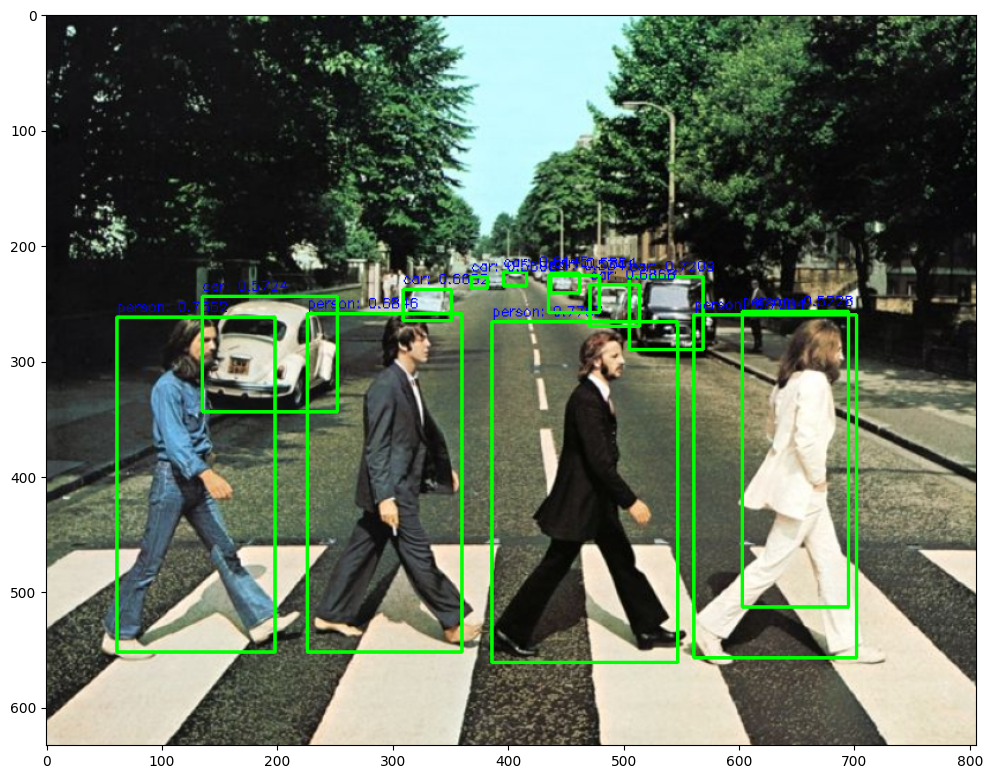

In [33]:
#detector_model = get_ssd_detector()

img_array = cv2.cvtColor(cv2.imread('/content/data/beatles01.jpg'), cv2.COLOR_BGR2RGB)
draw_img = get_detected_img(detector_model, img_array, score_threshold=0.5, object_show_count=100, is_print=True)

plt.figure(figsize=(12, 12))
plt.imshow(draw_img)


#Video Inference

In [38]:
!wget -O ./data/Jonh_Wick_small.mp4 https://github.com/chulminkw/DLCV/blob/master/data/video/John_Wick_small.mp4?raw=true


--2023-10-03 10:15:44--  https://github.com/chulminkw/DLCV/blob/master/data/video/John_Wick_small.mp4?raw=true
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/chulminkw/DLCV/raw/master/data/video/John_Wick_small.mp4 [following]
--2023-10-03 10:15:44--  https://github.com/chulminkw/DLCV/raw/master/data/video/John_Wick_small.mp4
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/chulminkw/DLCV/master/data/video/John_Wick_small.mp4 [following]
--2023-10-03 10:15:44--  https://raw.githubusercontent.com/chulminkw/DLCV/master/data/video/John_Wick_small.mp4
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.

In [35]:
def do_detected_video(model, input_path, output_path, score_threshold, is_print):

    cap = cv2.VideoCapture(input_path)

    codec = cv2.VideoWriter_fourcc(*'XVID')

    vid_size = (round(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),round(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    vid_fps = cap.get(cv2.CAP_PROP_FPS)

    vid_writer = cv2.VideoWriter(output_path, codec, vid_fps, vid_size)

    frame_cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print('총 Frame 갯수:', frame_cnt)

    green_color=(0, 255, 0)
    red_color=(0, 0, 255)
    while True:
        hasFrame, img_frame = cap.read()
        if not hasFrame:
            print('더 이상 처리할 frame이 없습니다.')
            break

        img_frame = get_detected_img(model, img_frame, score_threshold=score_threshold, object_show_count=100, is_print=is_print)

        vid_writer.write(img_frame)
    # end of while loop

    vid_writer.release()
    cap.release()

In [39]:
do_detected_video(detector_model, '/content/data/Jonh_Wick_small.mp4', './data/John_Wick_small_02.mp4', 0.5, True)

총 Frame 갯수: 58
car: 0.6785
car: 0.5698
car: 0.5395
Detection 수행시간: 0.11 초
car: 0.6946
car: 0.5763
car: 0.5395
Detection 수행시간: 0.13 초
motorcycle: 0.6226
person: 0.5840
car: 0.5559
Detection 수행시간: 0.09 초
car: 0.5359
person: 0.5348
car: 0.5228
Detection 수행시간: 0.1 초
car: 0.6281
car: 0.6254
motorcycle: 0.6097
person: 0.5842
Detection 수행시간: 0.14 초
car: 0.6241
person: 0.6053
car: 0.5280
Detection 수행시간: 0.11 초
car: 0.6307
person: 0.5982
car: 0.5157
Detection 수행시간: 0.13 초
car: 0.6952
person: 0.6058
motorcycle: 0.5257
motorcycle: 0.5150
Detection 수행시간: 0.14 초
person: 0.6923
car: 0.6280
motorcycle: 0.5511
car: 0.5127
Detection 수행시간: 0.18 초
person: 0.6850
car: 0.6466
car: 0.5946
motorcycle: 0.5325
Detection 수행시간: 0.17 초
car: 0.6627
car: 0.6265
person: 0.5025
Detection 수행시간: 0.17 초
car: 0.6668
car: 0.6445
person: 0.5397
motorcycle: 0.5068
Detection 수행시간: 0.17 초
person: 0.5929
car: 0.5350
Detection 수행시간: 0.12 초
person: 0.6150
car: 0.5573
car: 0.5510
person: 0.5106
person: 0.5007
Detection 수행시간: 0.12